---

# Generate datasets

In [1]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from simulation import Simulator

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

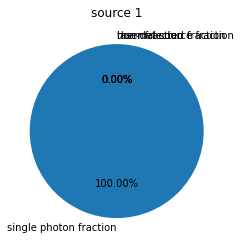

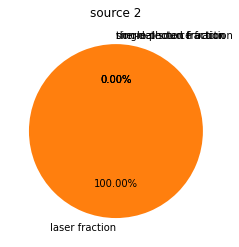

In [2]:
# create two mixed sources and corresponding two distributions
s1 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=1., laser=0., ther=0., non=0.)
s2 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=0., laser=1.0, ther=0., non=0.)

# plot their piecharts to see source fractions
plt.figure(1)
s1.piechart()
plt.title('source 1')
plt.figure(2)
s2.piechart()
plt.title('source 2')
plt.show()


In [3]:
# set data sets: x-> g2 signal, y -> actual result
# x_train = [] x_test = [] y_train = [] y_test = []
x_ = []
y_ = []
datasets = 500 + 500  # 50 for each distribution, 100 sets in total

In [51]:
# iterate over get_data function to collect data sets   
for i in range(datasets//2): 
    data = s1.get_data(dist=s1.distribution(),save=True, name='puresps'+str(i))
    x_.append(data[0])
    y_.append(data[2])
    
    data = s2.get_data(dist=s2.distribution(),save=True, name='laser'+str(i))
    x_.append(data[0])
    y_.append(data[2])
    

In [30]:
# load the data from files
filenames = []
x_ = []
y_ = []
filenames = ['./simulation/data/s1set'+str(i)+'.txt' for i in range(500)]+['./simulation/data/s2set'+str(i)+'.txt' for i in range(500)]

for filename in filenames: 
    data = s2.load_data(filename)
    x_.append(data[1])
    y_.append(data[0])

 we shuffle the data sets, and then allocate 70% of generated data sets for training the model and 30% for testing 


In [31]:
# convert them to np.array
x_ = np.array(x_)
y_ = np.array(y_)

# shuffle
i = np.random.permutation(len(x_))
x_ = x_[i]
y_ = y_[i]

# reshape
x_ = x_.reshape(x_.shape[0], x_.shape[1], 1)
y_ = y_.reshape(y_.shape[0])

# allocate
x_train = x_[:700]
y_train = y_[:700]
x_test = x_[700:]
y_test = y_[700:]

---
# CNN model

In [36]:
from tensorflow import keras

In [37]:
def make_model(input_shape):
    # input shape should be (time signal, 1)
    input_layer = keras.layers.Input(input_shape)

    # 1st con1d layer
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(input_layer)
    
    # 2nd con1d layer
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv1)

    # 3rd con1d layer
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv2)
    
    # maxpooling layer
    pool = keras.layers.MaxPool1D(pool_size=3, strides=1, padding='valid')(conv3) # keras.layers.GlobalAveragePooling1D()(conv3) #  # 
    
    # flatten layer
    flat = keras.layers.Flatten()(pool)
    
    # fully connected layer to output a binary vector
    dense1 = keras.layers.Dense(2, activation='relu')(flat)
    #dense2 = keras.layers.Dense(2, activation='relu')(dense1)

    return keras.models.Model(inputs=input_layer, outputs=dense1)


model = make_model(input_shape=x_train.shape[1:])


In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 199, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 64)           16448     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 190, 64)           16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 188, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12032)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 24066 

In [81]:
x_train.shape

(700, 200, 1)

In [39]:
epochs = 50
batch_size = 5

callbacks = [
    # save checkpoints
    keras.callbacks.ModelCheckpoint(
        "g2model.h5", save_best_only=True, monitor="val_loss"
    ),
    
    # if there's no improvement for minimizing losses, which makes the training stagnate
    # then reduce the learning rate
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    
    # stop training if a monitored metric stops improving
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/50
112/112 [==============================] - 1s 3ms/step - loss: 0.4134 - sparse_categorical_accuracy: 0.4834 - val_loss: 0.3608 - val_sparse_categorical_accuracy: 0.4929
Epoch 2/50
112/112 [==============================] - 0s 2ms/step - loss: 0.2755 - sparse_categorical_accuracy: 0.4410 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/50
112/112 [==============================] - 0s 2ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.4316 - val_loss: 0.0021 - val_sparse_categorical_accuracy: 0.5143
Epoch 4/50
112/112 [==============================] - 0s 2ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.5812 - val_loss: 0.0080 - val_sparse_categorical_accuracy: 0.0143
Epoch 5/50
112/112 [==============================] - 0s 2ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.5505 - val_loss: 5.3535e-04 - val_sparse_categorical_accuracy: 0.7786
Epoch 6/50
112/112 [==============================] - 0s 2ms/step - loss: 0.0014 - sparse_ca

In [40]:
model = keras.models.load_model('g2model.h5')

loss, accuracy = model.evaluate(x_test, y_test)

print("Test accuracy", accuracy)
print("Test loss", loss)


10/10 [==============================] - 0s 1ms/step - loss: 2.4027e-04 - sparse_categorical_accuracy: 0.8533
Test accuracy 0.8533333539962769
Test loss 0.00024027429753914475


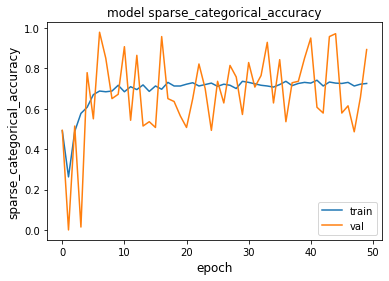

In [41]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


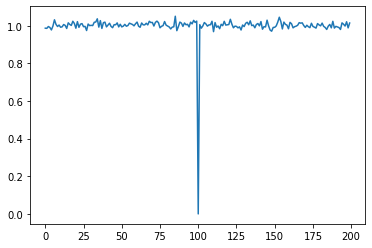

In [61]:
plt.plot(x_train[0])

In [65]:
y_train[0]

1

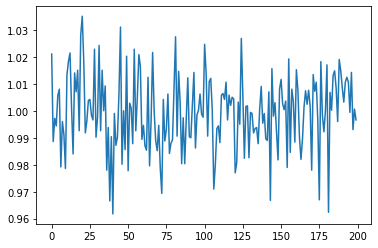

In [67]:
plt.plot(x_train[1])

In [89]:
np.loadtxt('./simulation/data/s1set10.txt', skiprows=9, max_rows=1)


array(1.)

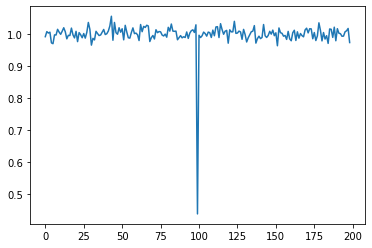

In [100]:
np.loadtxt('./simulation/data/s1set10.txt', skiprows=9, max_rows=1)
binnum = int(np.loadtxt('./simulation/data/s1set10.txt', skiprows=4, usecols=1, max_rows=1, delimiter=':'))
plt.plot(np.loadtxt('./simulation/data/s1set10.txt', skiprows=13, max_rows=binnum))


In [98]:
binnum = int(np.loadtxt('./simulation/data/s1set10.txt', skiprows=4, usecols=1, max_rows=1, delimiter=':'))


In [101]:
s1 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=1., laser=0., ther=0., non=0.)


In [102]:
s1.get_data(s1.distribution)

'please check your input distribution'

In [27]:
filenames = []
x_ = []
y_ = []
filenames = ['./simulation/data/s1set'+str(i)+'.txt' for i in range(500)]+['./simulation/data/s2set'+str(i)+'.txt' for i in range(500)]

for filename in filenames: 
    data = s2.load_data(filename)
    x_.append(data[1])
    y_.append(data[0])

In [29]:
len(x_)

1000